# Bayesian Model Comparison

What alternatives do we have for AIC and BIC when we don't have a maximum Liklihood?

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="talk", style="ticks", font="serif", color_codes=True)

np.random.seed(0)

In [2]:
c_true = (5, 0.12, 11/4)
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 1 + 5 * np.random.rand(N)
y = c_true[0] + c_true[1]*x + c_true[2]*x**2
y += yerr * np.random.randn(N)

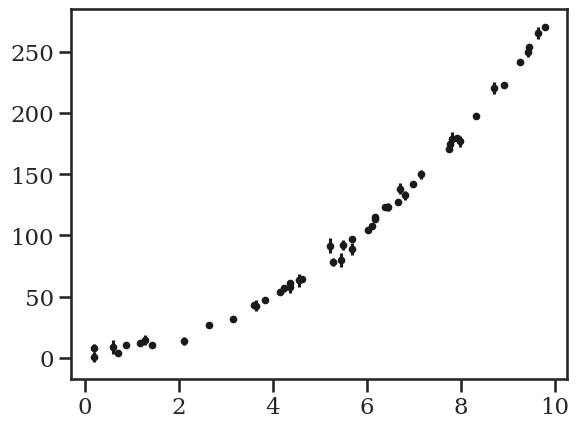

In [3]:
plt.errorbar(x, y, yerr=yerr, fmt="k.");

In [4]:
# model is y = c0 + c1*x + c2*x^2 + noise

# build a model via a `with` context block.
with pm.Model() as model:
    # define priors on polynomial coeffiencts and the added noise
    c0 = pm.Normal('c0', 0, 20)
    c1 = pm.Normal('c1', 0, 20)
    c2 = pm.Normal('c2', 0, 20)
    noise = pm.Exponential('noise', 0.1) #could be half-Normal or half-chauchy

    # define observations: y = c0 + c1*x + c2*x^2
    # link variables to data with `observed=y`
    obs = pm.Normal('obs', c0 + c1*x + c2*x**2, noise, observed=y)

    # run sampler
    idata_quad = pm.sample(idata_kwargs={"log_likelihood": True})

idata_quad

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, c2, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Inference data with groups:
        > posterior
        > log_likelihood
        > sample_stats
        > observed_data

In [5]:
# model is y = c0 + c1*x  + noise

# build a model via a `with` context block.
with pm.Model() as model:
    # define priors on polynomial coeffiencts and the added noise
    c0 = pm.Normal('c0', 0, 20)
    c1 = pm.Normal('c1', 0, 20)
    noise = pm.Exponential('noise', 0.1) #could be half-Normal or half-chauchy

    # define observations: y = c0 + c1*x + c2*x^2
    # link variables to data with `observed=y`
    obs = pm.Normal('obs', c0 + c1*x, noise, observed=y)

    # run sampler
    idata_linear = pm.sample(idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [6]:
# model is y = c0 + c1*x + c2*x^2 + c3*x^3  + noise

# build a model via a `with` context block.
with pm.Model() as model:
    # define priors on polynomial coeffiencts and the added noise
    c0 = pm.Normal('c0', 0, 20)
    c1 = pm.Normal('c1', 0, 20)
    c2 = pm.Normal('c2', 0, 20)
    c3 = pm.Normal('c3', 0, 20)
    noise = pm.Exponential('noise', 0.1) #could be half-Normal or half-chauchy

    # define observations: y = c0 + c1*x + c2*x^2 + c3*x^3
    # link variables to data with `observed=y`
    obs = pm.Normal('obs', c0 + c1*x + c2*x**2 + c3*x**3, noise, observed=y)

    # run sampler
    idata_cubic = pm.sample(idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, c2, c3, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


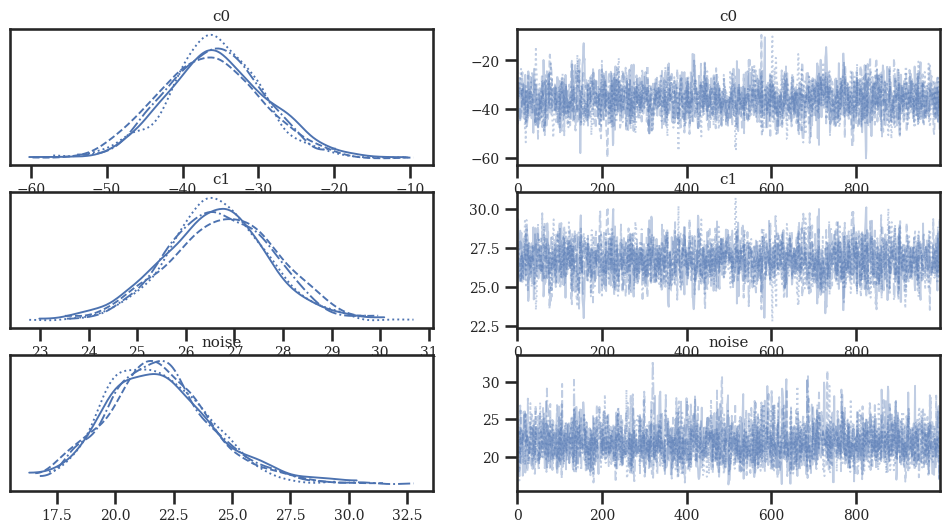

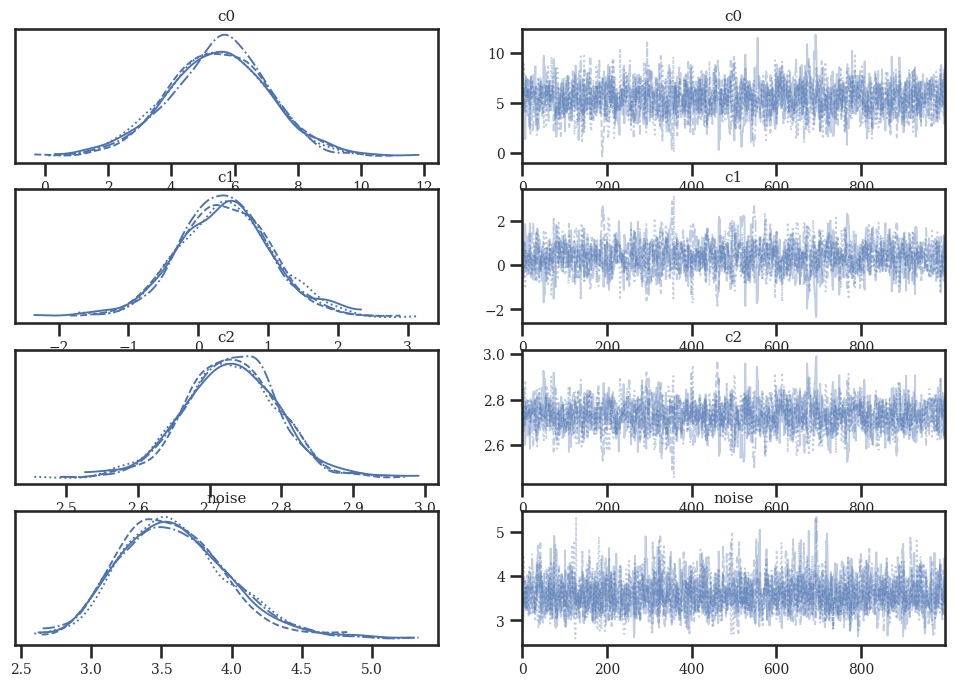

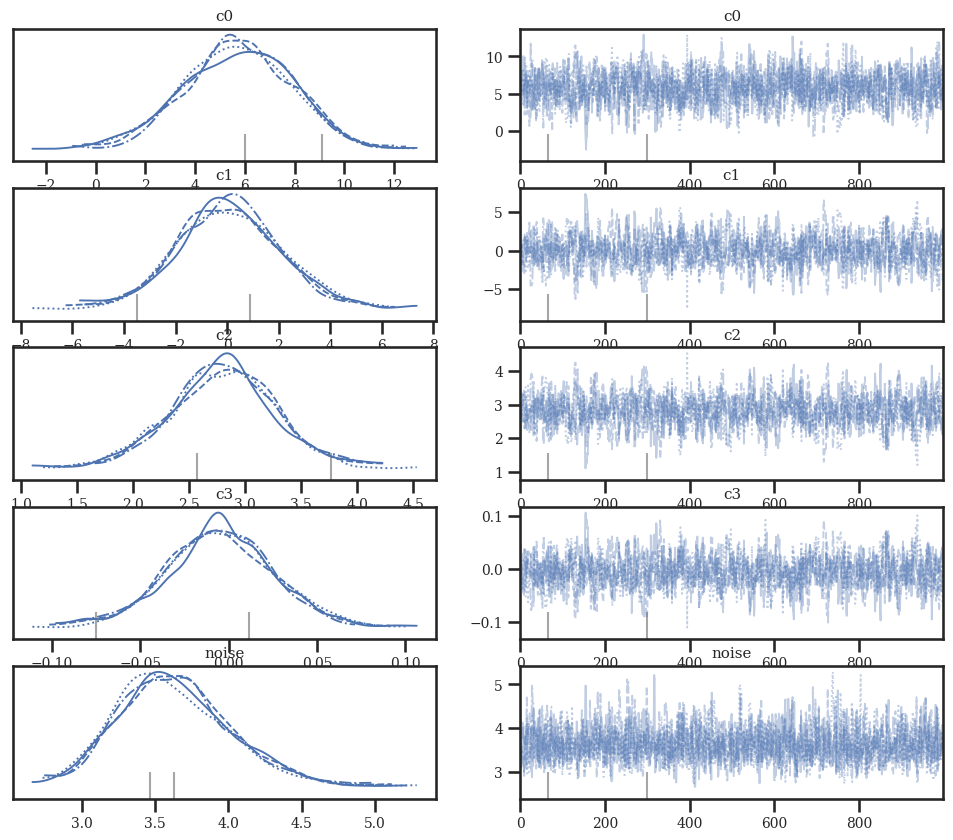

In [7]:
az.plot_trace(idata_linear)
az.plot_trace(idata_quad)
az.plot_trace(idata_cubic);

## Cross Valication & Leave-one-out

Gelman, Hill, & Vehtari section 11.8 describes the theory behind the following process

https://python.arviz.org/en/stable/api/generated/arviz.compare.html
https://python.arviz.org/en/latest/api/generated/arviz.plot_compare.html

Note, you need `idata_kwargs={"log_likelihood": True}` in the `pm.sample()` function in order to save the likelihoods needed for the fast leave-one-out calcualtions described in Gelman 11.8.

In [8]:
# Perform the Leave-one-out calcualtion
idata_linear = az.loo(idata_linear)
idata_quad = az.loo(idata_quad)
idata_cubic = az.loo(idata_cubic)

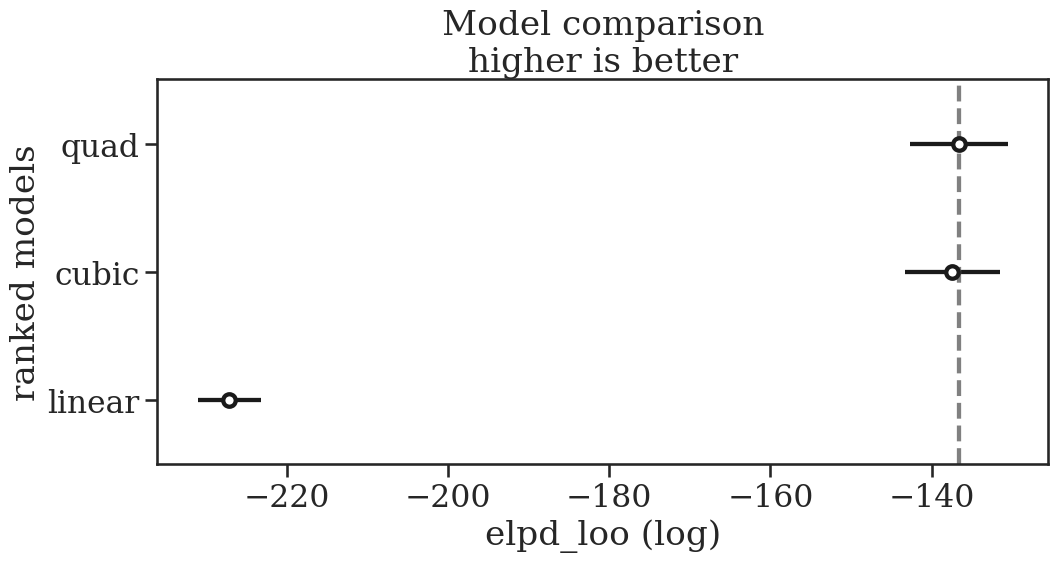

In [9]:
model_compare = az.compare(
    {
        "linear": idata_linear,
        "quad": idata_quad,
        "cubic": idata_cubic,
    }
)
az.plot_compare(model_compare, figsize=(11.5, 5));

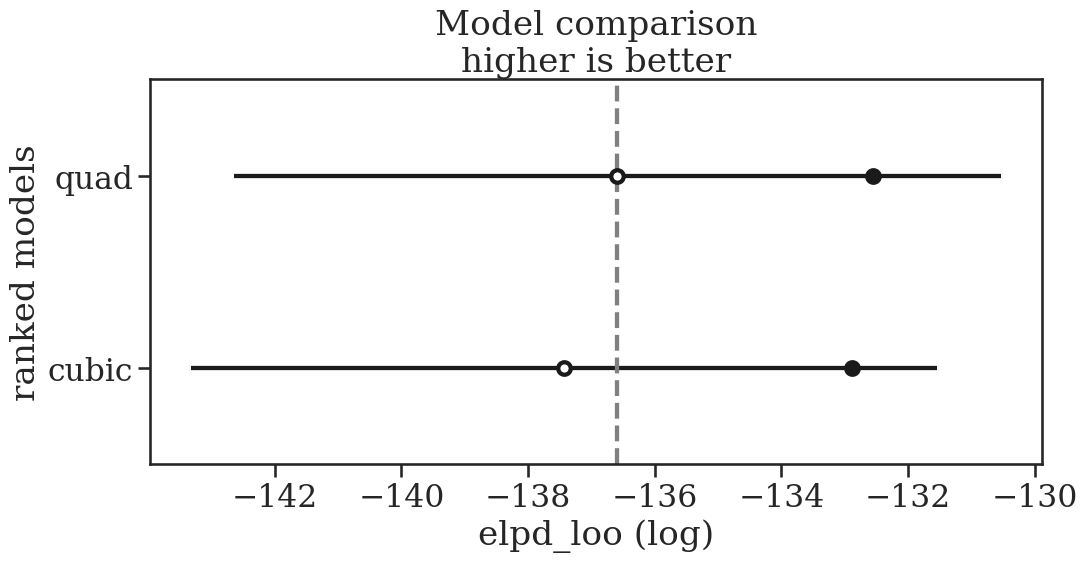

In [10]:
# Lets zoom in on quad and cubic
model_compare = az.compare(
    {
        "quad": idata_quad,
        "cubic": idata_cubic,
    }
)
az.plot_compare(model_compare, figsize=(11.5, 5), insample_dev=True);

---
## Further Reading

* Gelman, Hill, Vehtari chapter 11
* https://academic.oup.com/jrsssb/article/64/4/583/7098621
* https://arxiv.org/abs/1507.04544
* https://python.arviz.org/en/latest/api/generated/arviz.loo.html#arviz.loo
* https://python.arviz.org/en/stable/api/generated/arviz.compare.html
* https://python.arviz.org/en/latest/api/generated/arviz.plot_compare.html
* https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-model-selection.html

In [11]:
%load_ext watermark
%watermark -untzvm -iv -w

Last updated: Wed Apr 23 2025 13:53:53CDT

Python implementation: CPython
Python version       : 3.11.12
IPython version      : 9.1.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 12
Architecture: 64bit

pandas    : 2.2.3
numpy     : 1.25.2
rich      : 14.0.0
pymc      : 5.22.0
seaborn   : 0.13.2
matplotlib: 3.10.1
arviz     : 0.21.0

Watermark: 2.5.0

